In [1]:
import numpy as np
from datetime import datetime
from multiprocessing import Pool, cpu_count

In [3]:
datetime.now()

datetime.datetime(2019, 8, 13, 14, 55, 43, 671776)

## Create Fingerprints

In [5]:
import pandas as pd

dfs = pd.read_csv("./data/new_record2.csv", chunksize=100000)

In [6]:
from utils import encode


def custom_encode(record):
    return ' '.join(encode(record).astype(str))


encode_vectorize = np.vectorize(custom_encode)

In [11]:
fingerprints = None
i = 0
for df in dfs:
    i += 1
    print("COMPLETED", i / 100, datetime.now())
    df['HO_TEN'] = df.HO + " " + df.DEM + " " + df.TEN
    df.rename(columns={
        "NGAY": "NGAY_SINH",
        "THANG": "THANG_SINH",
        "NAM": "NAM_SINH"
    },
              inplace=True)
    records = np.array(df.to_dict('records'))
    num_cpu = cpu_count()
    blocks = np.split(records, num_cpu)
    p = Pool(num_cpu)
    fingerprint = np.concatenate(p.map(encode_vectorize, blocks))
    p.close()
    p.join()
    fingerprint = [np.array(i.split()).astype(bool) for i in fingerprint]
    fingerprint = np.array(fingerprint)
    if type(fingerprints) == type(None):
        fingerprints = np.copy(fingerprint)
    else:
        fingerprints = np.concatenate((fingerprints, fingerprint))

COMPLETED 0.01 2019-08-13 11:30:30.184376
COMPLETED 0.02 2019-08-13 11:31:01.780314
COMPLETED 0.03 2019-08-13 11:31:34.829239
COMPLETED 0.04 2019-08-13 11:32:07.413395
COMPLETED 0.05 2019-08-13 11:32:40.093465
COMPLETED 0.06 2019-08-13 11:33:14.492527
COMPLETED 0.07 2019-08-13 11:33:47.976472
COMPLETED 0.08 2019-08-13 11:34:20.640734
COMPLETED 0.09 2019-08-13 11:34:54.902268
COMPLETED 0.1 2019-08-13 11:35:30.323900
COMPLETED 0.11 2019-08-13 11:36:09.380631
COMPLETED 0.12 2019-08-13 11:36:44.238006
COMPLETED 0.13 2019-08-13 11:37:19.913190
COMPLETED 0.14 2019-08-13 11:37:57.941731
COMPLETED 0.15 2019-08-13 11:38:33.801208
COMPLETED 0.16 2019-08-13 11:39:09.302908
COMPLETED 0.17 2019-08-13 11:39:46.436468
COMPLETED 0.18 2019-08-13 11:40:23.652525
COMPLETED 0.19 2019-08-13 11:41:03.931886
COMPLETED 0.2 2019-08-13 11:41:44.578907
COMPLETED 0.21 2019-08-13 11:42:23.294864
COMPLETED 0.22 2019-08-13 11:43:01.393434
COMPLETED 0.23 2019-08-13 11:43:39.419455
COMPLETED 0.24 2019-08-13 11:44:18.2

OSError: [Errno 12] Cannot allocate memory

In [12]:
len(fingerprints)

5300000

In [38]:
import sys


def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['', 'Ki', 'Mi', 'Gi', 'Ti', 'Pi', 'Ei', 'Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)


for name, size in sorted(
    ((name, sys.getsizeof(value)) for name, value in locals().items()),
        key=lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                           ___:  2.6 KiB
                           _30:  2.6 KiB
                  MultibitTree:  1.0 KiB
                           _oh:  648.0 B
                           Out:  648.0 B
                            _i:  587.0 B
                           _i7:  587.0 B
                           _i8:  587.0 B
                           _i9:  587.0 B
                          _i37:  587.0 B


In [17]:
import pickle
with open('fingerprints.pickle', 'wb') as handle:
    pickle.dump(fingerprints, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Generate Multibit Tree

In [2]:
import pickle
with open("./fingerprints.pickle", 'rb') as handle:
    fingerprints = pickle.load(handle)

In [4]:
from tree import MultibitTree

In [5]:
tree = MultibitTree(fingerprints)

In [6]:
tree.build_tree()

In [37]:
import sys

In [20]:
with open('tree.pickle', 'wb') as handle:
    pickle.dump(tree, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [53]:
root_node = tree.tree

## Get 1 sample bucket (left side)

In [54]:
root_node.root.idx

249

In [55]:
for i in range(12):
    if np.random.rand() > 0.5:
        root_node = root_node.i_child
    else:
        root_node = root_node.o_child
    print(root_node.root.num_idx)

2641022
1319737
660310
329842
164159
81812
40906
20496
10262
5116
2630
1358


In [56]:
res = root_node.get_fingerprint_idx()

[<tree.Tree object at 0x7fdd867e36d8>, <tree.Tree object at 0x7fdd867e38d0>]


In [13]:
import numpy as np

In [57]:
bucket_idx = np.concatenate(res)

In [58]:
bucket_idx

array([  78257,   82424,   86591, ..., 5278798, 5295466, 5299633])

In [59]:
root_node.root.num_idx

1358

In [60]:
root_node

In [44]:
bucket_idx = root_node.root.fingerprint_indices

In [33]:
with open('bucket_sample.pickle', 'wb') as handle:
    pickle.dump(root_node.root.fingerprint_indices,
                handle,
                protocol=pickle.HIGHEST_PROTOCOL)

In [34]:
len(fingerprints)

5300000

In [61]:
# Test performance
import pandas as pd
dfs = pd.read_csv("./data/new_record2.csv", chunksize=100000)


In [62]:
bucket_records = []
for i, df in enumerate(dfs):
    start_idx = i * 100000    
    chosen_idx = bucket_idx[(bucket_idx>= start_idx)&(bucket_idx<start_idx+100000)]
    bucket_records.append(df.iloc[chosen_idx - start_idx])

In [63]:
pd.concat(bucket_records)

,Unnamed: 0,GIOI_TINH,MA_TINH_KS,MA_HUYEN_KS,MA_XA_KS,SO_CMTND,HO,DEM,TEN,NGAY,THANG,NAM
78257,78257,1,41TTT,137HH,17230,41214891479,Nguyễn,Văn,Thành,26,1,1914
82424,82424,1,39TTT,172HH,18965,39273490939,Park,Xuân,Nga,31,5,1973
86591,86591,1,39TTT,172HH,18965,39273490939,Park,Xuân,Nga,31,5,1973
90758,90758,1,08TTT,170HH,5612,8221428471,Đoàn,Thị Linh,Anh,29,1,1921
94925,94925,1,39TTT,172HH,18965,39273490939,Park,Xuân,Nga,31,5,1973
99092,99092,1,39TTT,172HH,18965,39273490939,Park,Xuân,Nga,31,5,1973
76903,76903,1,57TTT,085HH,9261,57014548208,Đỗ,Ngọc,Thoa,31,8,2014
81070,81070,0,53TTT,015HH,14371,53106272395,Phạm,Duy,Liên,12,4,2006
85237,85237,0,53TTT,015HH,14371,53106272395,Phạm,Duy,Liên,12,4,2006
89404,89404,0,55TTT,200HH,2781,55113471619,Vũ,Thị,Quang,7,2,2013


In [30]:
records = np.array(records)

In [43]:
res = 

In [46]:
import sys

In [98]:
sys.getsizeof(res)/1024**2 * 1e3/1024

2.7940720319747925

In [101]:
## Get full fingerprints





AttributeError: 'numpy.ndarray' object has no attribute 'split'

In [60]:
import pickle
with open('test_size.pickle', 'wb') as handle:
    pickle.dump(res, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [64]:
3000 * 12/1024

35.15625

In [70]:
bit_lengths = res.sum(axis = 1)

In [71]:
bit_lengths

array([185, 179, 206, ..., 181, 191, 184])

In [72]:
import matplotlib.pyplot as plt

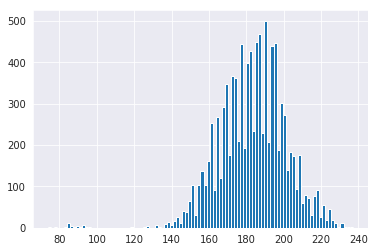

In [90]:
import seaborn as sns
sns.set_style("darkgrid")
plt.hist(bit_lengths, bins = 100)
plt.show()

In [76]:
from scipy import stats

In [77]:
most_freq_val = stats.mode(bit_lengths)

In [87]:
max_portion = (bit_lengths == most_freq_val.mode[0]).sum()/len(bit_lengths)

In [92]:
expected_tree_size = max_portion * 120e6

In [93]:
expected_tree_size

3228000.0

array([191])

In [57]:
np.bool??